<a href="https://colab.research.google.com/github/aqilahassan-hub/Multi-domain-Endoscopic-Surgeon-Action-Detection/blob/main/yolo_to_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
from IPython.display import Image  # for displaying images
import os, zipfile
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

import logging
logging.getLogger().setLevel(logging.CRITICAL)
!pip install pylabel > /dev/null

#!pip install pylabel

from pylabel import importer
from pylabel import *

from pathlib import PurePath

import yaml


In [24]:
!cat "/content/drive/MyDrive/Data Conversion/real1_frame_1005.txt"

3 0.62890625 0.359375 0.3609375 0.42291666666666666
5 0.72734375 0.5989583333333334 0.3015625 0.42291666666666666

In [25]:
!cat "/content/drive/MyDrive/Data Conversion/mesad.yaml"

# Training and Validation data paths
train: /content/drive/MyDrive/Data Conversion


# Number of Classes
nc: 21

# Class Names
names: [ "CuttingThread", "PullingVasDeferens", "PullingSeminalVesicle", "CuttingSeminalVesicle", 
         "ClippingBladderNeck", "SuckingSmoke", "SuckingBlood", "PullingProstate", "CuttingProstate", 
         "BaggingProstate", "CuttingTissue", "BladderNeckDissection", "ClippingSeminalVesicle", 
         "ClippingVasDeferens", "CuttingMesocolon", "CuttingVasDeferens", "PullingTissue", "BladderAnastomosis", 
         "ClippingTissue", "PullingBladderNeck", "UrethraDissection"]


In [29]:
data0 = importer.ImportYoloV5WithYaml(yaml_file="/content/drive/MyDrive/Data Conversion/mesad.yaml", 
                     path_to_annotations="/content/drive/MyDrive/Data Conversion/", 
                     image_ext='jpg',
                      name_of_annotations_folder="annotations")

In [30]:
#An example of what the data looks like
data0.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/drive/MyDrive/Data Conversion,real1_frame_1997.jpg,,0,720,576,3,,258.75,408.0,...,,,,,,16,PullingTissue,,train,1
1,/content/drive/MyDrive/Data Conversion,real1_frame_520.jpg,,1,720,576,3,,207.00,141.6,...,,,,,,14,CuttingMesocolon,,train,1
2,/content/drive/MyDrive/Data Conversion,real1_frame_520.jpg,,1,720,576,3,,231.75,322.8,...,,,,,,16,PullingTissue,,train,1
3,/content/drive/MyDrive/Data Conversion,real1_frame_523.jpg,,2,720,576,3,,207.00,141.6,...,,,,,,14,CuttingMesocolon,,train,1
4,/content/drive/MyDrive/Data Conversion,real1_frame_523.jpg,,2,720,576,3,,139.50,392.4,...,,,,,,16,PullingTissue,,train,1


In [31]:
#A sample of what the groupings look like
data0.df.groupby('split').count()

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_area,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,annotated
split,,,,,,,,,,,,,,,,,,,,,
train,1894,1894,1894,1894,1894,1894,1894,1894,1894,1894,...,1894,1894,1894,1894,1894,1894,1894,1894,1894,1894


In [34]:
from pylabel import importer

In [36]:
path_to_annotations = "/content/drive/MyDrive/Data Conversion/"

#Identify the path to get from the annotations to the images 
path_to_images = "/content/drive/MyDrive/Data Conversion/"

#Import the dataset into the pylable schema 
#Class names are defined here https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
yoloclasses = [ "CuttingThread", "PullingVasDeferens", "PullingSeminalVesicle", "CuttingSeminalVesicle", 
         "ClippingBladderNeck", "SuckingSmoke", "SuckingBlood", "PullingProstate", "CuttingProstate", 
         "BaggingProstate", "CuttingTissue", "BladderNeckDissection", "ClippingSeminalVesicle", 
         "ClippingVasDeferens", "CuttingMesocolon", "CuttingVasDeferens", "PullingTissue", "BladderAnastomosis", 
         "ClippingTissue", "PullingBladderNeck", "UrethraDissection"]

dataset = importer.ImportYoloV5(path=path_to_annotations, path_to_images=path_to_images, cat_names=yoloclasses,
    img_ext="jpg", name="coco128")

dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/drive/MyDrive/Data Conversion/,real1_frame_1997.jpg,,0,720,576,3,,258.75,408.0,...,,,,,,16,PullingTissue,,,1
1,/content/drive/MyDrive/Data Conversion/,real1_frame_520.jpg,,1,720,576,3,,207.00,141.6,...,,,,,,14,CuttingMesocolon,,,1
2,/content/drive/MyDrive/Data Conversion/,real1_frame_520.jpg,,1,720,576,3,,231.75,322.8,...,,,,,,16,PullingTissue,,,1
3,/content/drive/MyDrive/Data Conversion/,real1_frame_523.jpg,,2,720,576,3,,207.00,141.6,...,,,,,,14,CuttingMesocolon,,,1
4,/content/drive/MyDrive/Data Conversion/,real1_frame_523.jpg,,2,720,576,3,,139.50,392.4,...,,,,,,16,PullingTissue,,,1


In [37]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 1093
Number of classes: 12
Classes:['PullingVasDeferens', 'PullingSeminalVesicle', 'CuttingSeminalVesicle', 'SuckingSmoke', 'SuckingBlood', 'CuttingTissue', 'ClippingSeminalVesicle', 'ClippingVasDeferens', 'CuttingMesocolon', 'CuttingVasDeferens', 'PullingTissue', 'ClippingTissue']
Class counts:
PullingTissue             480
CuttingTissue             300
PullingSeminalVesicle     246
PullingVasDeferens        200
CuttingSeminalVesicle     194
CuttingMesocolon          182
SuckingSmoke              129
SuckingBlood               84
ClippingSeminalVesicle     35
ClippingVasDeferens        20
CuttingVasDeferens         16
ClippingTissue              8
Name: cat_name, dtype: int64


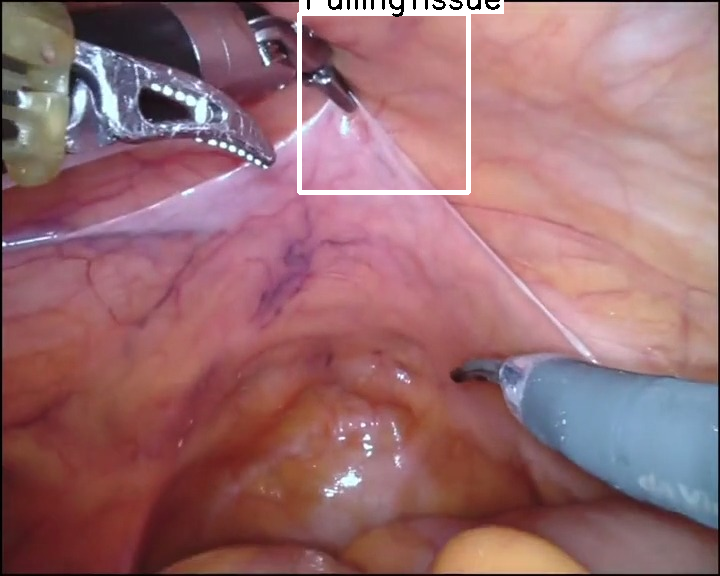

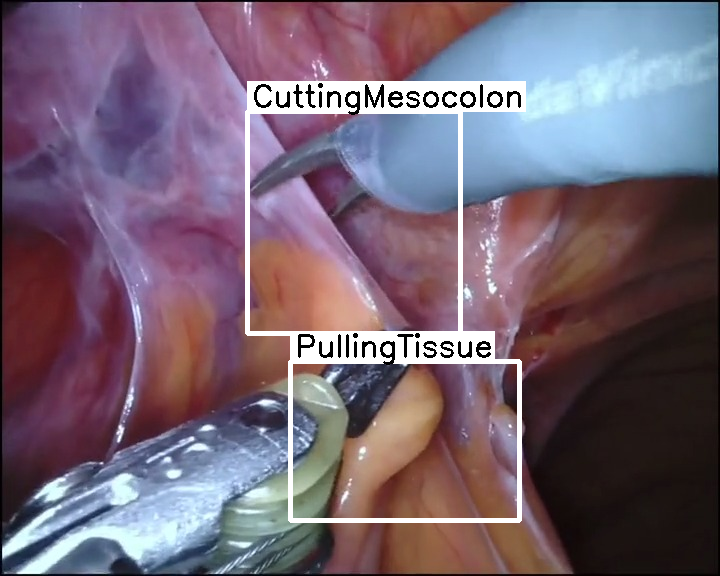

In [38]:
from IPython.display import Image, display
display(dataset.visualize.ShowBoundingBoxes(100))
display(dataset.visualize.ShowBoundingBoxes(30))

In [39]:
dataset.export.ExportToCoco(cat_id_index=1)

['/content/drive/MyDrive/Data Conversion/coco128.json']